In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import os
os.chdir('../')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import tcav
from src.download_data import download_imagenet, download_random_imagenet_classes
import pickle
from src.dataset import *
from src.concept_vectors import *
from src.util import *
import random
from src.plots import *
from sklearn.manifold import TSNE
from scipy.spatial.distance import cosine 
import pandas as pd
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
from src.hierarchy import *
from src.metrics import *
import pickle
import tensorflow as tf
import keras
from keras.models import load_model, Model

2023-01-17 20:49:16.978305: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from PIL import Image

In [16]:
mnist_attributes = get_mnist_attributes()

In [17]:
robustness_image_metric(create_linkage_hierarchy,load_tcav_vectors_simple,'mnist',mnist_attributes,[43,44,45])

Exception: No CAVs found at ./results/cavs/mnist/45

In [ ]:
responsiveness_image_metric(create_linkage_hierarchy,load_tcav_vectors_simple,'mnist',mnist_attributes,[43,44,45])

In [19]:
r = load_mnist(43,suffix="")

In [21]:
r[0]

{'img_path': 'colored_mnist/images/8/55234.png',
 'class_label': 8,
 'id': 55234,
 'attribute_label': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1]}

In [22]:
attribute = "0_color"
seed = 43
dataset = "mnist"
create_vector_from_label_mnist(attribute,seed=seed,suffix=dataset.replace("mnist",""))

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


OSError: [Errno 127] Key has expired: 'dataset/colored_mnist/images/train.pkl'

In [15]:
responsiveness_image_metric(create_linkage_hierarchy,load_label_vectors_simple,'mnist',mnist_attributes,[44,45])

KeyError: '0_color'

In [41]:
hierarchy_method = create_linkage_hierarchy
embedding_method = load_tcav_vectors_simple
dataset = 'mnist'
attributes = mnist_attributes[:4]
random_seeds = [43,44,45]
suffix = '_image_responsiveness'

In [42]:
baseline_hierarchies = [create_hierarchy(hierarchy_method,embedding_method,dataset,attributes,seed) for seed in random_seeds]
robustness_hierarchies = [create_hierarchy(hierarchy_method,embedding_method,dataset+'_image_robustness',attributes,seed) for seed in random_seeds]
responsiveness_hierarchies = [create_hierarchy(hierarchy_method,embedding_method,dataset+'_image_responsiveness',attributes,seed) for seed in random_seeds]

In [43]:
responsiveness_hierarchies[0].distance(baseline_hierarchies[0])

4.0

In [44]:
robustness_hierarchies[0].distance(baseline_hierarchies[0])

4.0

In [12]:
baseline_node = baseline_hierarchies[0].root_split.to_node()

In [13]:
responsivness_node = responsiveness_hierarchies[0].root_split.to_node()

In [14]:
simple_distance(baseline_node,responsivness_node)

6.0

In [19]:
for i in range(len(responsiveness_hierarchies)):
    print(responsiveness_hierarchies[i].distance(baseline_hierarchies[i]))

6.0
0.0
0.0


In [18]:
responsiveness_hierarchies[0].distance(baseline_hierarchies[0])

6.0

In [53]:
baseline_1_color = load_tcav_vectors_simple("1_color","mnist",seed=43)

In [54]:
responsiveness_1_color = load_tcav_vectors_simple("1_color","mnist_image_responsiveness",seed=43)

In [55]:
np.linalg.norm(baseline_1_color)

2823.778993652923

In [56]:
np.linalg.norm(responsiveness_1_color)

2285.4046393140497

In [62]:
for attribute in mnist_attributes[:4]:
    for suffix in ['','_image_robustness','_image_responsiveness']:
        print("{} {}".format(attribute,suffix))
        create_tcav_mnist(attribute,10,20,seed=43,suffix=suffix)

0_color 


/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:mixed4c ['0_color', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_8'] zebra 0.1


INFO:tensorflow:TCAV will 100 params


INFO:tensorflow:TCAV will 100 params


INFO:tensorflow:mixed4c ['0_color', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_9'] zebra 0.1


Pairs to test [('zebra', ['0_color', 'random500_0']), ('zebra', ['0_color', 'random500_1']), ('zebra', ['0_color', 'random500_2']), ('zebra', ['0_color', 'random500_3']), ('zebra', ['0_color', 'random500_4']), ('zebra', ['0_color', 'random500_5']), ('zebra', ['0_color', 'random500_6']), ('zebra', ['0_color', 'random500_7']), ('zebra', ['0_color', 'random500_8']), ('zebra', ['0_color', 'random500_9'])]
Params [<tcav.run_params.RunParams object at 0x7fd39870bb90>, <tcav.run_params.RunParams object at 0x7fd398731250>, <tcav.run_params.RunParams object at 0x7fd39870ba10>, <tcav.run_params.RunParams object at 0x7fd39870b6d0>, <tcav.run_params.RunParams object at 0x7fd39870bfd0>, <tcav.run_params.RunParams object at 0x7fd398731290>, <tcav.run_params.RunParams object at 0x7fd398731590>, <tcav.run_params.RunParams object at 0x7fd398731390>, <tcav.run_params.RunParams object at 0x7fd3987315d0>, <tcav.run_params.RunParams object at 0x7fd398731410>]
INFO:tensorflow:running 10 params


INFO:tensorflow:running 10 params


INFO:tensorflow:Running param 0 of 10


INFO:tensorflow:Running param 0 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_0']


INFO:tensorflow:running zebra ['0_color', 'random500_0']


INFO:tensorflow:./results/activations/acts_0_color_mixed4c does not exist, Making one...


INFO:tensorflow:./results/activations/acts_0_color_mixed4c does not exist, Making one...


INFO:tensorflow:Loaded ./results/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 0.5, 'random500_0': 0.6666666666666666, 'overall': 0.5714285714285714}


INFO:tensorflow:acc per class {'0_color': 0.5, 'random500_0': 0.6666666666666666, 'overall': 0.5714285714285714}


INFO:tensorflow:CAV accuracies: {'0_color': 0.5, 'random500_0': 0.6666666666666666, 'overall': 0.5714285714285714}


INFO:tensorflow:CAV accuracies: {'0_color': 0.5, 'random500_0': 0.6666666666666666, 'overall': 0.5714285714285714}


INFO:tensorflow:Running param 1 of 10


INFO:tensorflow:Running param 1 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_1']


INFO:tensorflow:running zebra ['0_color', 'random500_1']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_1_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_1_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_1': 0.6666666666666666, 'overall': 0.8571428571428571}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_1': 0.6666666666666666, 'overall': 0.8571428571428571}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_1': 0.6666666666666666, 'overall': 0.8571428571428571}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_1': 0.6666666666666666, 'overall': 0.8571428571428571}


INFO:tensorflow:Running param 2 of 10


INFO:tensorflow:Running param 2 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_2']


INFO:tensorflow:running zebra ['0_color', 'random500_2']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_2_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_2_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_2': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_2': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_2': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_2': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 3 of 10


INFO:tensorflow:Running param 3 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_3']


INFO:tensorflow:running zebra ['0_color', 'random500_3']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_3_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_3_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_3': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_3': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_3': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_3': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 4 of 10


INFO:tensorflow:Running param 4 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_4']


INFO:tensorflow:running zebra ['0_color', 'random500_4']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_4_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_4_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_4': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_4': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_4': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_4': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 5 of 10


INFO:tensorflow:Running param 5 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_5']


INFO:tensorflow:running zebra ['0_color', 'random500_5']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_5_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_5_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_5': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_5': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_5': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_5': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 6 of 10


INFO:tensorflow:Running param 6 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_6']


INFO:tensorflow:running zebra ['0_color', 'random500_6']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_6_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_6_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_6': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_6': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_6': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_6': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 7 of 10


INFO:tensorflow:Running param 7 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_7']


INFO:tensorflow:running zebra ['0_color', 'random500_7']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_7_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_7_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_7': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_7': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_7': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_7': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 8 of 10


INFO:tensorflow:Running param 8 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_8']


INFO:tensorflow:running zebra ['0_color', 'random500_8']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_8_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_8_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_8': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_8': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_8': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_8': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 9 of 10


INFO:tensorflow:Running param 9 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_9']


INFO:tensorflow:running zebra ['0_color', 'random500_9']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_9_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_9_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_9': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_9': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_9': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_9': 1.0, 'overall': 1.0}


INFO:tensorflow:Done running 10 params. Took 19.40566349029541 seconds...


INFO:tensorflow:Done running 10 params. Took 19.40566349029541 seconds...


0_color _image_robustness


/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:mixed4c ['0_color', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_8'] zebra 0.1


INFO:tensorflow:TCAV will 100 params


INFO:tensorflow:TCAV will 100 params


INFO:tensorflow:mixed4c ['0_color', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_9'] zebra 0.1


Pairs to test [('zebra', ['0_color', 'random500_0']), ('zebra', ['0_color', 'random500_1']), ('zebra', ['0_color', 'random500_2']), ('zebra', ['0_color', 'random500_3']), ('zebra', ['0_color', 'random500_4']), ('zebra', ['0_color', 'random500_5']), ('zebra', ['0_color', 'random500_6']), ('zebra', ['0_color', 'random500_7']), ('zebra', ['0_color', 'random500_8']), ('zebra', ['0_color', 'random500_9'])]
Params [<tcav.run_params.RunParams object at 0x7fd3982e5b90>, <tcav.run_params.RunParams object at 0x7fd3982e5e10>, <tcav.run_params.RunParams object at 0x7fd3982e5550>, <tcav.run_params.RunParams object at 0x7fd3982e5e90>, <tcav.run_params.RunParams object at 0x7fd3982e5510>, <tcav.run_params.RunParams object at 0x7fd3982e5fd0>, <tcav.run_params.RunParams object at 0x7fd3982e5ed0>, <tcav.run_params.RunParams object at 0x7fd3982e5c50>, <tcav.run_params.RunParams object at 0x7fd3982e51d0>, <tcav.run_params.RunParams object at 0x7fd3982e5bd0>]
INFO:tensorflow:running 10 params


INFO:tensorflow:running 10 params


INFO:tensorflow:Running param 0 of 10


INFO:tensorflow:Running param 0 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_0']


INFO:tensorflow:running zebra ['0_color', 'random500_0']


INFO:tensorflow:./results/activations/acts_0_color_mixed4c does not exist, Making one...


INFO:tensorflow:./results/activations/acts_0_color_mixed4c does not exist, Making one...


INFO:tensorflow:Loaded ./results/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_0': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_0': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_0': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_0': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 1 of 10


INFO:tensorflow:Running param 1 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_1']


INFO:tensorflow:running zebra ['0_color', 'random500_1']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_1_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_1_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_1': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_1': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_1': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_1': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 2 of 10


INFO:tensorflow:Running param 2 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_2']


INFO:tensorflow:running zebra ['0_color', 'random500_2']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_2_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_2_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_2': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_2': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_2': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_2': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 3 of 10


INFO:tensorflow:Running param 3 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_3']


INFO:tensorflow:running zebra ['0_color', 'random500_3']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_3_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_3_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_3': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_3': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_3': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_3': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 4 of 10


INFO:tensorflow:Running param 4 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_4']


INFO:tensorflow:running zebra ['0_color', 'random500_4']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_4_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_4_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_4': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_4': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_4': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_4': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 5 of 10


INFO:tensorflow:Running param 5 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_5']


INFO:tensorflow:running zebra ['0_color', 'random500_5']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_5_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_5_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_5': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_5': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_5': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_5': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 6 of 10


INFO:tensorflow:Running param 6 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_6']


INFO:tensorflow:running zebra ['0_color', 'random500_6']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_6_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_6_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_6': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_6': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_6': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_6': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 7 of 10


INFO:tensorflow:Running param 7 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_7']


INFO:tensorflow:running zebra ['0_color', 'random500_7']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_7_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_7_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_7': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_7': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_7': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_7': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 8 of 10


INFO:tensorflow:Running param 8 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_8']


INFO:tensorflow:running zebra ['0_color', 'random500_8']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_8_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_8_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_8': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_8': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_8': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_8': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 9 of 10


INFO:tensorflow:Running param 9 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_9']


INFO:tensorflow:running zebra ['0_color', 'random500_9']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_9_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_9_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_9': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_9': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_9': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_9': 1.0, 'overall': 1.0}


INFO:tensorflow:Done running 10 params. Took 18.45456600189209 seconds...


INFO:tensorflow:Done running 10 params. Took 18.45456600189209 seconds...


0_color _image_responsiveness


/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:mixed4c ['0_color', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_8'] zebra 0.1


INFO:tensorflow:TCAV will 100 params


INFO:tensorflow:TCAV will 100 params


INFO:tensorflow:mixed4c ['0_color', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['0_color', 'random500_9'] zebra 0.1


Pairs to test [('zebra', ['0_color', 'random500_0']), ('zebra', ['0_color', 'random500_1']), ('zebra', ['0_color', 'random500_2']), ('zebra', ['0_color', 'random500_3']), ('zebra', ['0_color', 'random500_4']), ('zebra', ['0_color', 'random500_5']), ('zebra', ['0_color', 'random500_6']), ('zebra', ['0_color', 'random500_7']), ('zebra', ['0_color', 'random500_8']), ('zebra', ['0_color', 'random500_9'])]
Params [<tcav.run_params.RunParams object at 0x7fd364624490>, <tcav.run_params.RunParams object at 0x7fd364624550>, <tcav.run_params.RunParams object at 0x7fd364624590>, <tcav.run_params.RunParams object at 0x7fd3646241d0>, <tcav.run_params.RunParams object at 0x7fd3646246d0>, <tcav.run_params.RunParams object at 0x7fd364624690>, <tcav.run_params.RunParams object at 0x7fd3646247d0>, <tcav.run_params.RunParams object at 0x7fd3646240d0>, <tcav.run_params.RunParams object at 0x7fd364624450>, <tcav.run_params.RunParams object at 0x7fd364624750>]
INFO:tensorflow:running 10 params


INFO:tensorflow:running 10 params


INFO:tensorflow:Running param 0 of 10


INFO:tensorflow:Running param 0 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_0']


INFO:tensorflow:running zebra ['0_color', 'random500_0']


INFO:tensorflow:./results/activations/acts_0_color_mixed4c does not exist, Making one...


INFO:tensorflow:./results/activations/acts_0_color_mixed4c does not exist, Making one...


INFO:tensorflow:Loaded ./results/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_0': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_0': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_0': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_0': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 1 of 10


INFO:tensorflow:Running param 1 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_1']


INFO:tensorflow:running zebra ['0_color', 'random500_1']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_1_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_1_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_1': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_1': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_1': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_1': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 2 of 10


INFO:tensorflow:Running param 2 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_2']


INFO:tensorflow:running zebra ['0_color', 'random500_2']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_2_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_2_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_2': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_2': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_2': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_2': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 3 of 10


INFO:tensorflow:Running param 3 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_3']


INFO:tensorflow:running zebra ['0_color', 'random500_3']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_3_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_3_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_3': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_3': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_3': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_3': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 4 of 10


INFO:tensorflow:Running param 4 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_4']


INFO:tensorflow:running zebra ['0_color', 'random500_4']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_4_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_4_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_4': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_4': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_4': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_4': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 5 of 10


INFO:tensorflow:Running param 5 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_5']


INFO:tensorflow:running zebra ['0_color', 'random500_5']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_5_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_5_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_5': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_5': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_5': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_5': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 6 of 10


INFO:tensorflow:Running param 6 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_6']


INFO:tensorflow:running zebra ['0_color', 'random500_6']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_6_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_6_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_6': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_6': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_6': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_6': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 7 of 10


INFO:tensorflow:Running param 7 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_7']


INFO:tensorflow:running zebra ['0_color', 'random500_7']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_7_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_7_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_7': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_7': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_7': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_7': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 8 of 10


INFO:tensorflow:Running param 8 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_8']


INFO:tensorflow:running zebra ['0_color', 'random500_8']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_8_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_8_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_8': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_8': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_8': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_8': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 9 of 10


INFO:tensorflow:Running param 9 of 10


INFO:tensorflow:running zebra ['0_color', 'random500_9']


INFO:tensorflow:running zebra ['0_color', 'random500_9']


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_0_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_9_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_9_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['0_color', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['0_color', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_9': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'0_color': 1.0, 'random500_9': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_9': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'0_color': 1.0, 'random500_9': 1.0, 'overall': 1.0}


INFO:tensorflow:Done running 10 params. Took 19.651509761810303 seconds...


INFO:tensorflow:Done running 10 params. Took 19.651509761810303 seconds...


1_color 


/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:mixed4c ['1_color', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_8'] zebra 0.1


INFO:tensorflow:TCAV will 100 params


INFO:tensorflow:TCAV will 100 params


INFO:tensorflow:mixed4c ['1_color', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['1_color', 'random500_9'] zebra 0.1


Pairs to test [('zebra', ['1_color', 'random500_0']), ('zebra', ['1_color', 'random500_1']), ('zebra', ['1_color', 'random500_2']), ('zebra', ['1_color', 'random500_3']), ('zebra', ['1_color', 'random500_4']), ('zebra', ['1_color', 'random500_5']), ('zebra', ['1_color', 'random500_6']), ('zebra', ['1_color', 'random500_7']), ('zebra', ['1_color', 'random500_8']), ('zebra', ['1_color', 'random500_9'])]
Params [<tcav.run_params.RunParams object at 0x7fd50f8183d0>, <tcav.run_params.RunParams object at 0x7fd50f818890>, <tcav.run_params.RunParams object at 0x7fd50f8188d0>, <tcav.run_params.RunParams object at 0x7fd50f818050>, <tcav.run_params.RunParams object at 0x7fd50f818850>, <tcav.run_params.RunParams object at 0x7fd50f8189d0>, <tcav.run_params.RunParams object at 0x7fd50f818bd0>, <tcav.run_params.RunParams object at 0x7fd50f818a90>, <tcav.run_params.RunParams object at 0x7fd50f818a10>, <tcav.run_params.RunParams object at 0x7fd50f818ad0>]
INFO:tensorflow:running 10 params


INFO:tensorflow:running 10 params


INFO:tensorflow:Running param 0 of 10


INFO:tensorflow:Running param 0 of 10


INFO:tensorflow:running zebra ['1_color', 'random500_0']


INFO:tensorflow:running zebra ['1_color', 'random500_0']


INFO:tensorflow:./results/activations/acts_1_color_mixed4c does not exist, Making one...


INFO:tensorflow:./results/activations/acts_1_color_mixed4c does not exist, Making one...


INFO:tensorflow:Loaded ./results/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['1_color', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['1_color', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'1_color': 0.5, 'random500_0': 1.0, 'overall': 0.7142857142857143}


INFO:tensorflow:acc per class {'1_color': 0.5, 'random500_0': 1.0, 'overall': 0.7142857142857143}


INFO:tensorflow:CAV accuracies: {'1_color': 0.5, 'random500_0': 1.0, 'overall': 0.7142857142857143}


INFO:tensorflow:CAV accuracies: {'1_color': 0.5, 'random500_0': 1.0, 'overall': 0.7142857142857143}


INFO:tensorflow:Running param 1 of 10


INFO:tensorflow:Running param 1 of 10


INFO:tensorflow:running zebra ['1_color', 'random500_1']


INFO:tensorflow:running zebra ['1_color', 'random500_1']


INFO:tensorflow:Loaded ./results/activations/acts_1_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_1_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_1_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_1_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['1_color', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['1_color', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'1_color': 0.5, 'random500_1': 0.6666666666666666, 'overall': 0.5714285714285714}


INFO:tensorflow:acc per class {'1_color': 0.5, 'random500_1': 0.6666666666666666, 'overall': 0.5714285714285714}


INFO:tensorflow:CAV accuracies: {'1_color': 0.5, 'random500_1': 0.6666666666666666, 'overall': 0.5714285714285714}


INFO:tensorflow:CAV accuracies: {'1_color': 0.5, 'random500_1': 0.6666666666666666, 'overall': 0.5714285714285714}


INFO:tensorflow:Running param 2 of 10


INFO:tensorflow:Running param 2 of 10


INFO:tensorflow:running zebra ['1_color', 'random500_2']


INFO:tensorflow:running zebra ['1_color', 'random500_2']


INFO:tensorflow:Loaded ./results/activations/acts_1_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_1_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_2_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_2_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['1_color', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['1_color', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'1_color': 0.75, 'random500_2': 1.0, 'overall': 0.8571428571428571}


INFO:tensorflow:acc per class {'1_color': 0.75, 'random500_2': 1.0, 'overall': 0.8571428571428571}


INFO:tensorflow:CAV accuracies: {'1_color': 0.75, 'random500_2': 1.0, 'overall': 0.8571428571428571}


INFO:tensorflow:CAV accuracies: {'1_color': 0.75, 'random500_2': 1.0, 'overall': 0.8571428571428571}


INFO:tensorflow:Running param 3 of 10


INFO:tensorflow:Running param 3 of 10


INFO:tensorflow:running zebra ['1_color', 'random500_3']


INFO:tensorflow:running zebra ['1_color', 'random500_3']


INFO:tensorflow:Loaded ./results/activations/acts_1_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_1_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_3_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_3_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['1_color', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['1_color', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'1_color': 1.0, 'random500_3': 0.8571428571428571, 'overall': 0.9285714285714286}


INFO:tensorflow:acc per class {'1_color': 1.0, 'random500_3': 0.8571428571428571, 'overall': 0.9285714285714286}


INFO:tensorflow:CAV accuracies: {'1_color': 1.0, 'random500_3': 0.8571428571428571, 'overall': 0.9285714285714286}


INFO:tensorflow:CAV accuracies: {'1_color': 1.0, 'random500_3': 0.8571428571428571, 'overall': 0.9285714285714286}


INFO:tensorflow:Running param 4 of 10


INFO:tensorflow:Running param 4 of 10


INFO:tensorflow:running zebra ['1_color', 'random500_4']


INFO:tensorflow:running zebra ['1_color', 'random500_4']


INFO:tensorflow:Loaded ./results/activations/acts_1_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_1_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_4_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_4_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['1_color', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['1_color', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'1_color': 1.0, 'random500_4': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'1_color': 1.0, 'random500_4': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'1_color': 1.0, 'random500_4': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'1_color': 1.0, 'random500_4': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 5 of 10


INFO:tensorflow:Running param 5 of 10


INFO:tensorflow:running zebra ['1_color', 'random500_5']


INFO:tensorflow:running zebra ['1_color', 'random500_5']


INFO:tensorflow:Loaded ./results/activations/acts_1_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_1_color_mixed4c shape (20, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_5_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_random500_5_mixed4c shape (50, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded ./results/activations/acts_zebra_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Training CAV ['1_color', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['1_color', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'1_color': 1.0, 'random500_5': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'1_color': 1.0, 'random500_5': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'1_color': 1.0, 'random500_5': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'1_color': 1.0, 'random500_5': 1.0, 'overall': 1.0}


RuntimeError: can't start new thread

In [37]:
seed = 43
experiment_name = "mnist_image_responsiveness"
model_name = "GoogleNet"
bottlenecks = ['mixed4c']

np.random.seed(seed)
random.seed(seed)

activation_dir = './results/activations'
working_dir = './results/tmp'
image_dir = "./dataset/images"

sess = utils.create_session()
if model_name == "GoogleNet":
    GRAPH_PATH = "./dataset/models/inception5h/tensorflow_inception_graph.pb"
    LABEL_PATH = "./dataset/models/inception5h/imagenet_comp_graph_label_strings.txt"
    mymodel = model.GoogleNetWrapper_public(sess,
                                        GRAPH_PATH,
                                        LABEL_PATH)
else:
    raise Exception("create_tcav_vectors not implemented for {}".format(model_name))

In [32]:
cav_dir = './results/cavs/{}/{}'.format(experiment_name,seed)
act_generator = act_gen.ImageActivationGenerator(mymodel, image_dir, activation_dir, max_examples=100)

In [40]:
train = pickle.load(open("dataset/colored_mnist/images/train.pkl","rb"))
train_robust = pickle.load(open("dataset/colored_mnist_robustness/images/train.pkl","rb"))

In [49]:
for i in range(len(train)):
    if train[i]['attribute_label'] != train_robust[i]['attribute_label']:
        break
print(i)

3


In [45]:
model = load_pb("dataset/models/inception5h/tensorflow_inception_graph.pb")

In [48]:
type(model)

tensorflow.core.framework.graph_pb2.GraphDef

In [47]:
nodes = [n for n in model.node]

In [50]:
model.node = []

AttributeError: Assignment not allowed to repeated field "node" in protocol message object.

In [33]:
len(nodes)

370

In [36]:
wts = [n for n in nodes if n.op=='Const']

In [37]:
len(wts)

142

In [43]:
tensor_util.MakeNdarray(wts[0].attr['value'].tensor)

array([[[[ 3.37403446e-01, -2.18586564e-01,  4.69391495e-01, ...,
           3.69904965e-01, -1.10782415e-01, -3.93793955e-02],
         [ 4.31445450e-01, -1.75220668e-02,  6.91341460e-01, ...,
           5.95482469e-01, -3.99538755e-01, -6.21756732e-01],
         [-4.96600270e-01,  1.70150518e-01,  4.61964101e-01, ...,
           1.67223707e-01,  1.93537205e-01, -6.97964430e-02]],

        [[-3.27045679e-01,  4.27685454e-02,  8.98371756e-01, ...,
           1.16720390e+00,  1.29545480e-02, -4.19095695e-01],
         [ 8.85567129e-01,  3.13477039e-01,  1.42584944e+00, ...,
           1.15248489e+00,  4.33744669e-01,  4.27265167e-02],
         [-2.46043801e-01, -8.23620781e-02,  7.89139986e-01, ...,
           2.79848456e-01,  2.37074703e-01, -3.69647294e-01]],

        [[ 4.45822269e-01, -1.31578624e-01,  6.03718877e-01, ...,
           6.37285113e-01, -2.01918617e-01, -3.21208477e-01],
         [ 1.17013708e-01, -2.34289169e-01,  1.62318766e+00, ...,
           8.35187793e-01,  3.0695

In [35]:
new_model = load_model("dataset/models/inception5h/tensorflow_inception_graph.pb")

OSError: Unable to open file (file signature not found)

In [52]:
sess = utils.create_session()
model_name = "GoogleNet"
if model_name == "GoogleNet":
    GRAPH_PATH = "./dataset/models/inception5h/tensorflow_inception_graph.pb"
    LABEL_PATH = "./dataset/models/inception5h/imagenet_comp_graph_label_strings.txt"
    mymodel = model.GoogleNetWrapper_public(sess,
                                        GRAPH_PATH,
                                        LABEL_PATH)

2023-01-11 16:08:15.581702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-11 16:08:15.589275: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [67]:
tf.train.list_variables("./dataset/models/inception5h/tensorflow_inception_graph.pb")

2023-01-11 16:16:54.169013: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./dataset/models/inception5h/tensorflow_inception_graph.pb: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


DataLossError: Unable to open table file ./dataset/models/inception5h/tensorflow_inception_graph.pb: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?

In [57]:
names = [n.name for n in sess.graph_def.node]


In [75]:
[i for i in sess.graph.get_operations() if ':' in i.name]

[]

In [79]:
tvars = tf.trainable_variables()

AttributeError: module 'tensorflow' has no attribute 'trainable_variables'

In [64]:
v1 = sess.graph.get_tensor_by_name('v1/mixed4a_5x5')

ValueError: The name 'v1/mixed4a_5x5' refers to an Operation, not a Tensor. Tensor names must be of the form "<op_name>:<output_index>".

In [52]:
regular_image = "dataset/colored_mnist/images/0/9994.png"
robust_image = "dataset/colored_mnist_robustness/images/0/9994.png"
responsive_image = "dataset/colored_mnist_responsiveness/images/0/9994.png"

<IPython.core.display.Javascript object>


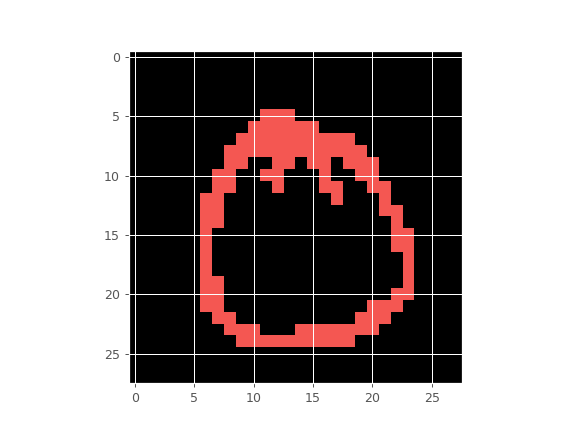

In [53]:
plt.figure()
plt.imshow(Image.open(regular_image))

<IPython.core.display.Javascript object>


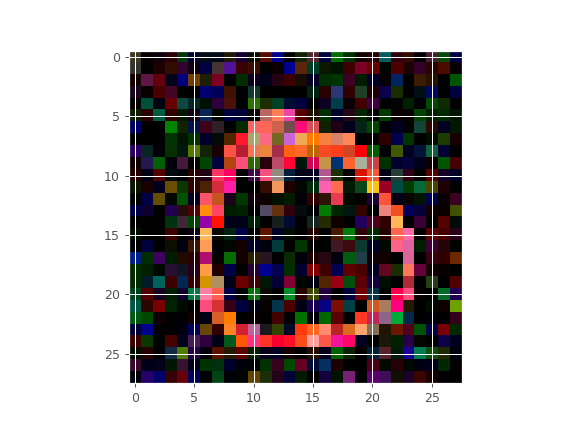

In [54]:
plt.figure()
plt.imshow(Image.open(robust_image))

<IPython.core.display.Javascript object>


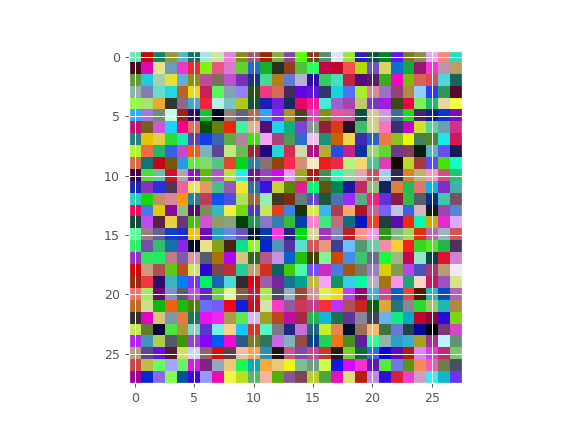

In [55]:
plt.figure()
plt.imshow(Image.open(responsive_image))

In [4]:
load_cem_vectors("xor",0,42).shape

(48, 16)

In [5]:
load_tcav_vectors("soccer",['mixed4c'],experiment_name="unfiled")[0].shape

(2, 100352)

In [6]:
load_label_vectors_simple("has_bill_shape::dagger","cub",seed=42).shape

(1, 4796)

In [7]:
load_cem_vectors_simple('0','xor',seed=42).shape

(48, 16)

In [5]:
mnist_attributes = ['{}_color'.format(i) for i in range(5)] + ['{}_number'.format(i) for i in range(5)]

In [6]:
stability_metric(create_linkage_hierarchy,load_tcav_vectors_simple,'mnist',mnist_attributes,[43,44,45])

14.0

In [7]:
stability_metric(create_ward_hierarchy,load_tcav_vectors_simple,'mnist',mnist_attributes,[43,44,45])

16.333333333333332

In [8]:
stability_metric(create_ward_hierarchy,load_cem_vectors_simple,'mnist',mnist_attributes,[43,44,45])

19.666666666666668

In [9]:
stability_metric(create_ward_hierarchy,load_label_vectors_simple,'mnist',mnist_attributes,[43,44,45])

0.0

In [18]:
np.load('./results/cem_concepts/mnist/43/mnist_concept_0_inactive.npy')

array([], shape=(0, 16), dtype=float64)

In [20]:
stability_metric(create_linkage_hierarchy,load_cem_vectors_simple,'mnist',mnist_attributes,[45,45])

0.0

In [27]:
h1 = create_hierarchy(create_ward_hierarchy,load_cem_vectors_simple, 'xor',['0','1'],42)

In [28]:
h2 = create_hierarchy(create_linkage_hierarchy,load_tcav_vectors_simple, 'unfiled',['soccer','alga'],42)

In [29]:
h3 = create_hierarchy(create_linkage_hierarchy,load_label_vectors_simple, 'cub',["has_bill_shape::dagger",'has_bill_shape::hooked_seabird'],42)

In [33]:
len(str(h1))

32

In [34]:
len(str(h2))

40

In [35]:
len(str(h3))

82

In [40]:
assert type(h1) == type(h2) == type(h3)